$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Training set size and accuracy of reduced bases

We're looking at how well the quality of a reduced basis changes with the size of the training set that goes in to the OMP / greedy procedure


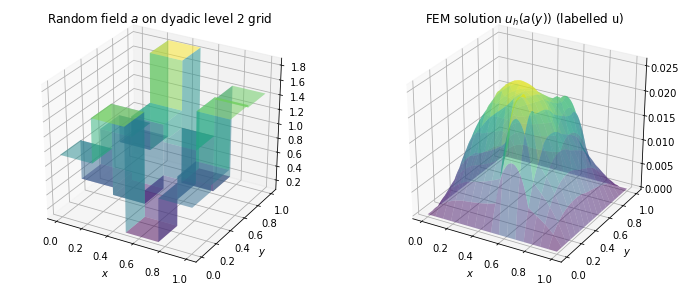

In [1]:
import numpy as np
import math
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

def make_soln(points, fem_space, field_space, a_bar=1.0, c=0.5, f=1.0, verbose=False):

    solns = hil.Basis(np.zeros((H1_fine.n, len(points))), space=H1_fine)
    fields = []
    for i, p in enumerate(points):
        field = hil.Vector(a_bar + c * p, space=field_space)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = hil.DyadicFEMSolver(fem_space = fem_space, rand_field = field, f = 1)
        fem_solver.solve()
        solns._values[:,i] = fem_solver.u.values
        
    return solns, fields

fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
field_div = 2
L2_coarse = hil.L2DyadicSq(field_div)
a_bar = 0.1
c = 2.0
side_n = 4

def diffusion_pde(points):
    solns, fields = make_soln(points, fem_space=H1_fine, field_space=L2_coarse, a_bar=a_bar, c=c)
    return solns

np.random.seed(1)
u, a = make_soln(np.random.random((1,side_n**2)), fem_space=H1_fine, field_space=L2_coarse, a_bar=a_bar, c=c)
u = u[0]; a = a[0]
                           
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
N_tr = 10000
N_te = 10000

d = side_n * side_n

y_range = np.zeros((d,2))
y_range[:,1] = 1

np.random.seed(1)
points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_tr = diffusion_pde(points_tr)
points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_te = diffusion_pde(points_te)

### Now with the large dictionary computed, we perform OMP on a subsets of that dictionary, with some relationship between our target $n$ and the size of the dictionary

We consider the approximation error of our reduced basis (constructed using OMP or similar)

$$
\varepsilon(n, \mathcal{D}) := \max_{u\in\mathcal{D}} \| u - P_{V_n} u \|
$$

First we just look at the approximation error for a variety of $N = \#(\mathcal{D})$

In [4]:
import copy

n = 40
Ns = [n, 100, 500, 1000, 5000, 10000]
Vns = [us_tr[:Ns[0]]]

for N in Ns[1:]:
    print(f'Constructing greedy with dict size {N}...')
    greedy = rm.GreedyApprox(us_tr[:N])
    Vn = copy.copy(greedy.construct_to_n(n))
    Vns.append(Vn)
    del greedy

Constructing greedy with dict size 100...
Constructing greedy with dict size 500...
Constructing greedy with dict size 1000...
Constructing greedy with dict size 5000...
Constructing greedy with dict size 10000...


Now we need to test the residuals for each basis. We do it here against a test set separate to the training set

In [5]:
avg_errors = np.zeros((len(Vns), max([Vn.n for Vn in Vns])))
max_errors = np.zeros((len(Vns), max([Vn.n for Vn in Vns])))
for i, Vn in enumerate(Vns):
    print(f'Calculating error for Vn constructed from dict of size {Ns[i]}')
    
    # First we project to the one vector, which doesn't have a routine
    v = Vn[0] / Vn[0].norm()
    us_te_proj = (us_te.A @ v)
    errors = np.array([(us_te[i] - us_te_proj[i]*v).norm() for i in range(us_te.n)])
    max_errors[i, 0] = errors.max()
    avg_errors[i, 0] = errors.mean()
    
    for n_trunc in range(1, Vn.n):
        Vn_trunc_ortho = Vn[:n_trunc+1].orthonormalise()
        us_te_proj = Vn_trunc_ortho @ (Vn_trunc_ortho.A @ us_te)
        errors = (us_te - us_te_proj).norms()

        max_errors[i, n_trunc] = errors.max()
        avg_errors[i, n_trunc] = errors.mean()

Calculating error for Vn constructed from dict of size 40
Calculating error for Vn constructed from dict of size 100
Calculating error for Vn constructed from dict of size 500
Calculating error for Vn constructed from dict of size 1000
Calculating error for Vn constructed from dict of size 5000
Calculating error for Vn constructed from dict of size 10000


Now lets plot the error curves. In the results below **each $V_n$ is constructed from a training set $\mathcal{Tr}$ of varying size $N$ from 40 to 10,000.** Each $V_n$ is constructed up to $n_{\mathrm{max}} = 40$, and we look at the approximation quality of each $V_n$ for varying $n$.

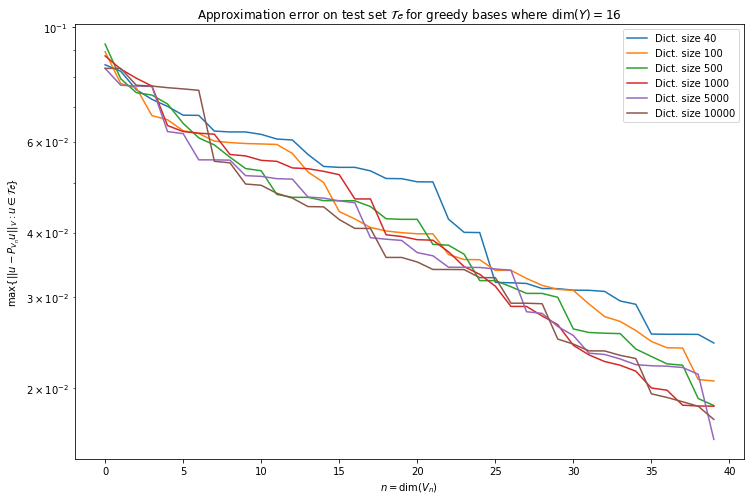

In [32]:
fig = plt.figure(figsize=(12, 8))
for i, N in enumerate(Ns):
    plt.semilogy(max_errors[i,:], label=f'Dict. size {N}')
plt.xlabel(rf'$n = \mathrm{{dim}}(V_n)$')
plt.ylabel(rf'$\mathrm{{max}} \{{ || u - P_{{V_n}} u ||_V : u \in \mathcal{{Te}} \}}$')
plt.title(rf'Approximation error on test set $\mathcal{{Te}}$ for greedy bases where $\mathrm{{dim}}(Y)={d}$')
plt.legend(loc=1)
plt.show()

### Now we load results from the scripts we've been running...

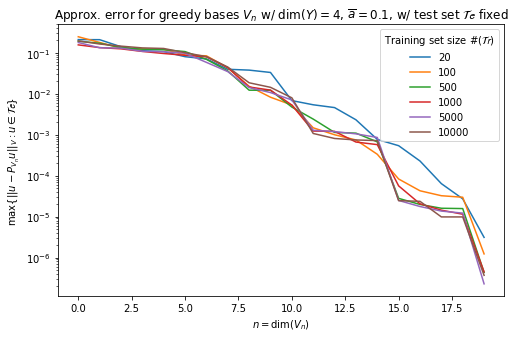

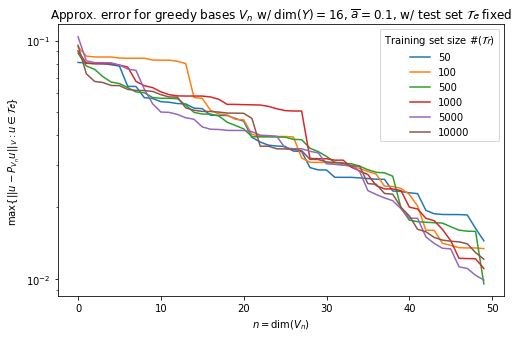

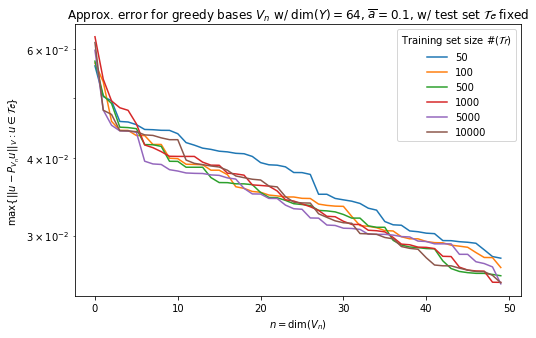

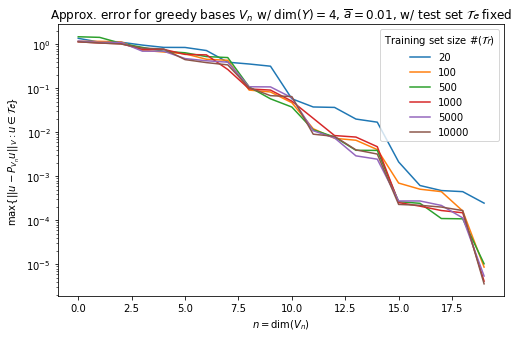

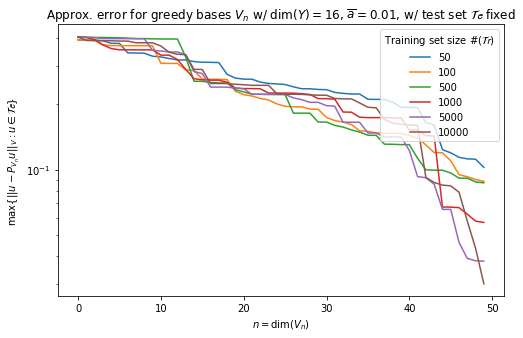

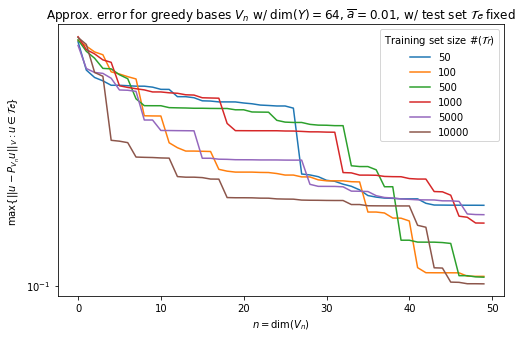

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for a_bar_load in [0.1, 0.01]:
    for field_div_load in [1,2,3]:
        #a_bar_load = 0.01
        #field_div_load = 1
        d_load = 2**(2*field_div_load)

        file = f'./scripts/results/max_errors_{d_load}_{a_bar_load}.npy'
        max_err_load = np.load(file)
        file = f'./scripts/results/avg_errors_{d_load}_{a_bar_load}.npy'
        avg_err_load = np.load(file)

        if field_div_load < 2:
            n = 20
        else:
            n = 50
        Ns = [n, 100, 500, 1000, 5000, 10000]

        fig = plt.figure(figsize=(8, 5))
        for i, N in enumerate(Ns):
            plt.semilogy(max_err_load[i,:], label=f'{N}')
        plt.xlabel(rf'$n = \mathrm{{dim}}(V_n)$')
        plt.ylabel(rf'$\mathrm{{max}} \{{ || u - P_{{V_n}} u ||_V : u \in \mathcal{{Te}} \}}$')
        plt.title(rf'Approx. error for greedy bases $V_n$ w/ $\mathrm{{dim}}(Y)={d_load}$, $\overline{{a}} = {a_bar_load}$, w/ test set $\mathcal{{Te}}$ fixed')
        plt.legend(loc=1, title=r'Training set size $\#(\mathcal{{Tr}})$')
        plt.savefig(f'figs/01_max_err_rb_{d_load}_{a_bar_load}.png')
        plt.savefig(f'figs/01_max_err_rb_{d_load}_{a_bar_load}.pdf')
        plt.show()


Say we have a dictionary $\mathcal{D}_N$ of size $N = \#(\mathcal{D}_N) = n^\alpha$ for some $\alpha$ (this is in line with the theory), then we look at $\varepsilon(n, \mathcal{D}_N)$ as we change $n$. This is _not a nested procedure_, that is we need to redo the complete greedy algorithm each time. We examine the quality of approximations